# MCP Guided Chat Workbench

This notebook provides an ipywidgets **chat UI** to walk through an MCP-style workflow:

**Request → Discover tools → Capability catalog → Plan (Gemini optional) → Execute → Verify → Summary**, with an **audit log**.

- Simulated backend servers: crm-server, analytics-server, slides-server with tool specs, resources, and prompt templates.
- FailureInjector to simulate latency, timeouts, errors, and stale responses.
- MCPRegistry and MCPServer classes for capability registration and audit collection.
- Heuristic and Gemini-based planner (plan_with_gemini) to convert user requests into structured plans.
- Executor (execute_plan) that runs plans via mcp_call, applies permissions, idempotency, and side-effect handling.
- Simple ipywidgets chat UI to drive the flow and display catalog, plan, transcript, and summary.
- Visual diagnostic cell to plot call outcomes and durations.

In [2]:
# ==== Controls ====
USE_GEMINI = True
GEMINI_MODEL = "gemini-2.5-flash"
if USE_GEMINI:
    from google.colab import userdata
    try:
        import google.generativeai as genai
        genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
    except Exception:
        print("Install google-generativeai to enable live calls.")

ROLE = "analyst"              # "analyst" or "manager"
REGION = "west"               # "east" or "west"
FAILURE_RATE = 0.15           # 0.0 (easy) ... 0.35 (noisier)
STEP_BUDGET = 60

import uuid
RUN_ID = f"mcpchat-{uuid.uuid4().hex[:8]}"
print({"RUN_ID": RUN_ID, "USE_GEMINI": USE_GEMINI, "ROLE": ROLE, "REGION": REGION, "FAILURE_RATE": FAILURE_RATE, "STEP_BUDGET": STEP_BUDGET})

{'RUN_ID': 'mcpchat-da63f0cc', 'USE_GEMINI': True, 'ROLE': 'analyst', 'REGION': 'west', 'FAILURE_RATE': 0.15, 'STEP_BUDGET': 60}


In [18]:
import random, time, json
from dataclasses import dataclass, field
from typing import Any, Dict, List, Callable

random.seed(7)
def _now_ms(): 
    return int(time.time() * 1000)

ACCOUNTS = [
    {"account_id":"A0100",  "name":"Acme Health",        "owner":"Riley",  "region":"west"},
    {"account_id":"A0200",  "name":"Beacon Retail",      "owner":"Zhu",    "region":"west"},
    {"account_id":"A0300",  "name":"Cobalt Finance",     "owner":"Sam",    "region":"east"},
    {"account_id":"A0400",  "name":"Delta Studios",      "owner":"Riley",  "region":"west"},
    {"account_id":"A0500",  "name":"Epsilon Logistics",  "owner":"Jordan", "region":"east"},
    {"account_id":"A0600",  "name":"Fjord Foods",        "owner":"Alex",   "region":"west"},
    {"account_id":"A0700",  "name":"Garnet Insurance",   "owner":"Priya",  "region":"east"},
    {"account_id":"A0800",  "name":"Helios Energy",      "owner":"Lee",    "region":"west"},
    {"account_id":"A0900",  "name":"Indigo Labs",        "owner":"Morgan", "region":"east"},
    {"account_id":"A1000", "name":"Juniper Media",      "owner":"Casey",  "region":"west"},
    {"account_id":"A1100", "name":"Kestrel Travel",     "owner":"Taylor", "region":"east"},
    {"account_id":"A1200", "name":"Lumen Pharma",       "owner":"Riley",  "region":"west"},
    {"account_id":"A1300", "name":"Mosaic Homes",       "owner":"Zhu",    "region":"east"},
    {"account_id":"A1400", "name":"Nova Robotics",      "owner":"Sam",    "region":"west"},
    {"account_id":"A1500", "name":"Orchid Supply",      "owner":"Jordan", "region":"east"},
    {"account_id":"A1600", "name":"Praxis Cloud",       "owner":"Alex",   "region":"west"},
    {"account_id":"A1700", "name":"Quartz Mining",      "owner":"Priya",  "region":"east"},
    {"account_id":"A1800", "name":"Riverview Bank",     "owner":"Lee",    "region":"west"},
    {"account_id":"A1900", "name":"Solstice Apparel",   "owner":"Morgan", "region":"east"},
    {"account_id":"A2000", "name":"Titan Motors",       "owner":"Casey",  "region":"west"},
]

def gen_series(seed, base=10000):
    random.seed(seed); s=[]; v=base+random.randint(-500,500)
    for _ in range(90):
        v+=random.randint(-120,120); v=max(0,v); s.append(v)
    return s

USAGE = {
    "A0100":  {"daily_active": gen_series(11,  300)},
    "A0200":  {"daily_active": gen_series(22,  150)},
    "A0300":  {"daily_active": gen_series(33,  500)},
    "A0400":  {"daily_active": gen_series(44,  120)},
    "A0500":  {"daily_active": gen_series(55,  260)},
    "A0600":  {"daily_active": gen_series(66,  410)},
    "A0700":  {"daily_active": gen_series(77,  180)},
    "A0800":  {"daily_active": gen_series(88,  340)},
    "A0900":  {"daily_active": gen_series(99,  220)},
    "A1000": {"daily_active": gen_series(111, 290)},
    "A1100": {"daily_active": gen_series(122, 130)},
    "A1200": {"daily_active": gen_series(133, 470)},
    "A1300": {"daily_active": gen_series(144, 360)},
    "A1400": {"daily_active": gen_series(155, 200)},
    "A1500": {"daily_active": gen_series(166, 140)},
    "A1600": {"daily_active": gen_series(177, 250)},
    "A1700": {"daily_active": gen_series(188, 320)},
    "A1800": {"daily_active": gen_series(199, 380)},
    "A1900": {"daily_active": gen_series(211, 210)},
    "A2000": {"daily_active": gen_series(222, 170)},
}

class FailureInjector:
    def __init__(self, rate=0.1, latency=True): self.rate=rate; self.latency=latency
    def maybe_fail(self):
        if self.latency: time.sleep(random.uniform(0.01,0.05))
        r=random.random()
        if r<self.rate*0.25: raise TimeoutError("simulated timeout")
        if r<self.rate*0.5:  raise ValueError("simulated 404/bad-id")
        if r<self.rate*0.75: return {"stale": True}
        return {}
FAIL=FailureInjector(rate=FAILURE_RATE, latency=True)

@dataclass
class ToolSpec:
    name:str; inputs:Dict[str,Any]; outputs:Dict[str,Any]; permissions:List[str]; side_effects:bool=False; version:str="v1"
@dataclass
class ToolResult:
    status:str; data:Dict[str,Any]=field(default_factory=dict); errors:List[str]=field(default_factory=list)
    evidence:List[Dict[str,str]]=field(default_factory=list); idempotency_key:str=""; version:str="v1"; duration_ms:int=0
@dataclass
class ResourceSpec: path:str; description:str
@dataclass
class PromptSpec: name:str; params:Dict[str,Any]; template:str
@dataclass
class MCPServer:
    name:str
    tools:Dict[str,ToolSpec]=field(default_factory=dict)
    resources:Dict[str,ResourceSpec]=field(default_factory=dict)
    prompts:Dict[str,PromptSpec]=field(default_factory=dict)
    impls:Dict[str,Callable]=field(default_factory=dict)
    idem_store:Dict[str,ToolResult]=field(default_factory=dict)

class MCPRegistry:
    def __init__(self): self.servers={}; self.audit=[]
    def register(self, server:MCPServer): self.servers[server.name]=server
REG=MCPRegistry()

def validate_inputs(spec:ToolSpec,args:Dict[str,Any])->List[str]:
    errs=[]
    for k,rule in spec.inputs.items():
        if rule.get("required") and k not in args: errs.append(f"missing required '{k}'")
        if k in args and "type" in rule:
            if rule["type"]=="string" and not isinstance(args[k],str): errs.append(f"'{k}' must be string")
            if rule["type"]=="number" and not isinstance(args[k],(int,float)): errs.append(f"'{k}' must be number")
        if k in args and "enum" in rule and args[k] not in rule["enum"]: errs.append(f"'{k}' must be one of {rule['enum']}")
    return errs

def mcp_call(server, tool, args, role, idem_key=None):
    start=_now_ms(); srv=REG.servers[server]; spec=srv.tools[tool]
    if role not in spec.permissions:
        res=ToolResult(status="error",errors=[f"permission denied for role '{role}'"],version=spec.version); res.duration_ms=_now_ms()-start
        REG.audit.append({"ts":_now_ms(),"server":server,"tool":tool,"args":args,"role":role,"result":res.__dict__}); return res
    v=validate_inputs(spec,args)
    if v:
        res=ToolResult(status="error",errors=v,version=spec.version); res.duration_ms=_now_ms()-start
        REG.audit.append({"ts":_now_ms(),"server":server,"tool":tool,"args":args,"role":role,"result":res.__dict__}); return res
    idem_key = idem_key or (f"{server}:{tool}:{json.dumps(args,sort_keys=True)}" if spec.side_effects else "")
    if spec.side_effects and idem_key in srv.idem_store:
        prev=srv.idem_store[idem_key]
        res=ToolResult(status="ok",data=prev.data,evidence=prev.evidence,idempotency_key=idem_key,version=spec.version); res.duration_ms=_now_ms()-start
        REG.audit.append({"ts":_now_ms(),"server":server,"tool":tool,"args":args,"role":role,"result":res.__dict__,"note":"idempotent-return"}); return res
    try:
        mark=FAIL.maybe_fail(); out=srv.impls[tool](args,mark)
        res=ToolResult(status="ok",data=out["data"],evidence=out.get("evidence",[]),idempotency_key=idem_key,version=spec.version)
        if spec.side_effects and not out.get("post_ok",True): res=ToolResult(status="error",errors=["postcondition failed"],idempotency_key=idem_key,version=spec.version)
        if spec.side_effects and res.status=="ok": srv.idem_store[idem_key]=res
    except Exception as e:
        res=ToolResult(status="error",errors=[str(e)],idempotency_key=idem_key,version=spec.version)
    res.duration_ms=_now_ms()-start
    REG.audit.append({"ts":_now_ms(),"server":server,"tool":tool,"args":args,"role":role,"result":res.__dict__})
    return res

# Servers
crm=MCPServer("crm-server")
crm.tools["accounts.search"]=ToolSpec("accounts.search", {"region":{"type":"string","required":True}}, {"accounts":{"type":"array"}}, ["analyst","manager"])
def impl_accounts_search(args,mark):
    region=args["region"]; accts=[a for a in ACCOUNTS if a["region"]==region]
    if mark.get("stale"): accts=accts[:-1] or accts
    return {"data":{"accounts":accts}, "evidence":[{"type":"source","url":f"crm://accounts?region={region}"}]}
crm.impls["accounts.search"]=impl_accounts_search
crm.resources["accounts/{id}/notes"]=ResourceSpec("accounts/{id}/notes","Latest CSM notes")
crm.prompts["summarize-account"]=PromptSpec("summarize-account", {"tone":"string"}, "Summarize {{account_name}} in a {{tone}} tone.")
REG.register(crm)

analytics=MCPServer("analytics-server")
analytics.tools["usage.get"]=ToolSpec("usage.get", {"account_id":{"type":"string","required":True}}, {"daily_active":{"type":"array"},"trend_14":{"type":"number"}}, ["analyst","manager"])
def impl_usage_get(args,mark):
    aid=args["account_id"]; series=USAGE[aid]["daily_active"]
    if mark.get("stale"): series=series[:-7]+[sum(series[-14:-7])//7]*7
    trend=(series[-1]-series[-14])/max(1,series[-14])
    return {"data":{"daily_active":series,"trend_14":trend}, "evidence":[{"type":"source","url":f"analytics://usage/{aid}"}]}
analytics.impls["usage.get"]=impl_usage_get
REG.register(analytics)

slides=MCPServer("slides-server")
slides.tools["slides.create"]=ToolSpec("slides.create", {"deck_spec":{"type":"object","required":True}}, {"slide_id":{"type":"string"}}, ["analyst","manager"], side_effects=True)
SLIDE_STORE={}
def impl_slides_create(args,mark):
    ds=args["deck_spec"]; idem=ds.get("idem") or f"{ds.get('account_id','?')}-auto"
    if idem in SLIDE_STORE: sid=SLIDE_STORE[idem]
    else: sid=f"S{len(SLIDE_STORE)+1:03d}"; SLIDE_STORE[idem]=sid
    post_ok=sid in SLIDE_STORE.values()
    return {"data":{"slide_id":sid}, "evidence":[{"type":"artifact","url":f"slides://{sid}"}], "post_ok":post_ok}
slides.impls["slides.create"]=impl_slides_create
REG.register(slides)
print("Servers ready:", list(REG.servers.keys()))

Servers ready: ['crm-server', 'analytics-server', 'slides-server']


In [19]:
import pandas as pd, json, re, os
from IPython.display import Markdown, display

def discover_capabilities():
    rows=[]
    for sname,srv in REG.servers.items():
        for tname,ts in srv.tools.items():
            rows.append({"server":sname,"kind":"tool","name":tname,"side_effects":ts.side_effects,"permissions":",".join(ts.permissions),
                         "inputs":json.dumps(ts.inputs),"outputs":json.dumps(ts.outputs),"version":ts.version})
        for rname,rs in srv.resources.items():
            rows.append({"server":sname,"kind":"resource","name":rname,"desc":rs.description})
        for pname,ps in srv.prompts.items():
            rows.append({"server":sname,"kind":"prompt","name":pname,"params":json.dumps(ps.params)})
    return pd.DataFrame(rows)

def heuristic_plan(user_msg, catalog_df):
    return {"steps":[{"server":"crm-server","tool":"accounts.search","args":{"region":REGION},"assign":"accounts"}]}

import json, base64

def parse_gemini_json(resp):
    """
    Extract JSON when using response_mime_type='application/json'.
    Tries text, then candidate parts (text or inline_data 'application/json').
    Raises with useful finish_reasons if nothing found.
    """
    if getattr(resp, "text", None):
        t = resp.text.strip()
        if t:
            try:
                return json.loads(t)
            except Exception:
                pass  # fall through to parts

    cands = getattr(resp, "candidates", []) or []
    for c in cands:
        content = getattr(c, "content", None)
        parts = getattr(content, "parts", []) if content else []
        for p in parts:
            if getattr(p, "text", None):
                t = p.text.strip()
                if t:
                    # Handle accidental fences or trailing prose
                    try:
                        return json.loads(t)
                    except Exception:
                        # last {...} block heuristic
                        import re
                        m = re.search(r"\{[\s\S]*\}\s*$", t)
                        if m:
                            return json.loads(m.group(0))
            # Inline data (common when response_mime_type = application/json)
            if hasattr(p, "inline_data"):
                mime = getattr(p.inline_data, "mime_type", "")
                data = getattr(p.inline_data, "data", "")
                if mime == "application/json" and data:
                    decoded = base64.b64decode(data).decode("utf-8")
                    return json.loads(decoded)

    reasons = [getattr(c, "finish_reason", None) for c in cands]
    raise RuntimeError(f"No JSON found in Gemini response. finish_reasons={reasons}")

def plan_with_gemini(user_msg, catalog_df):
    try:
        model=genai.GenerativeModel(
            GEMINI_MODEL,
            generation_config={
                "response_mime_type":"application/json",
                "temperature":0.0,
            })
        tools_as_text = catalog_df.to_json(orient="records")
        sys=("You are a planner for an MCP system. Given a user request and a capability catalog, "
             "return STRICT JSON with a 'steps' array: each {server, tool, args (object), assign(optional)}. No commentary.")
        prompt=f"{sys} User request: \n {user_msg} \n Catalog JSON: {tools_as_text} \n Return ONLY JSON"
        resp=model.generate_content(prompt)
        js = parse_gemini_json(resp)
        return js
    except Exception as e:
        raise RuntimeError(f"Gemini call failed: {e}")

def execute_plan(plan, role=ROLE, step_budget=STEP_BUDGET):
    transcript=[]; steps_used=0
    def log(msg): transcript.append(msg)
    accounts=[]
    for st in plan.get("steps", []):
        if steps_used>=step_budget: log(f"**Stop**: budget {step_budget}"); break
        if st["server"]=="crm-server" and st["tool"]=="accounts.search":
            steps_used+=1
            res=mcp_call("crm-server","accounts.search",st["args"],role=role)
            if res.status=="ok":
                accounts=res.data.get("accounts",[]); log(f"**accounts.search ok** → {len(accounts)} accounts")
            else:
                log(f"**accounts.search error** → {res.errors}")
            break
    for acct in accounts:
        if steps_used>=step_budget: log(f"**Stop**: budget {step_budget}"); break
        aid=acct["account_id"]; aname=acct["name"]; owner=acct["owner"]
        steps_used+=1
        ures=mcp_call("analytics-server","usage.get",{"account_id":aid},role=role)
        if ures.status!="ok": log(f"- usage.get **error** for {aid}: {ures.errors}"); continue
        slide={"account_id":aid,"account_name":aname,"owner":owner,"usage_trend_14":round(ures.data["trend_14"],3),"citations":ures.evidence}
        steps_used+=1
        deck_spec={**slide,"idem":f"{aid}-mcp"}
        cres=mcp_call("slides-server","slides.create",{"deck_spec":deck_spec},role=role,idem_key=f"slides:{aid}")
        if cres.status=="ok": log(f"- slides.create **ok** for {aid} → `{cres.data['slide_id']}`")
        else: log(f"- slides.create **error** for {aid}: {cres.errors}")
    return transcript

def catalog_md(df):
    head=df.head(12)
    lines=["| server | kind | name | side_effects | permissions |","|---|---|---|---|---|"]
    for _,r in head.iterrows():
        lines.append(f"| {r.get('server','')} | {r.get('kind','')} | {r.get('name','')} | {r.get('side_effects','')} | {r.get('permissions','')} |")
    if len(df)>12: lines.append(f"… ({len(df)-12} more rows)")
    return "\n".join(lines)

### Workflow
1) User sends a natural-language request via the chat UI.
2) Discover capabilities to build a catalog.
3) Plan generation: try Gemini planner; fallback to heuristic.
4) Execute plan: call tools (accounts.search, usage.get, slides.create), record transcript and audit.
5) Summarize results and show catalog, JSON plan, execution transcript, and audit metrics.

In [20]:
import ipywidgets as widgets
from IPython.display import display, Markdown

chat_box = widgets.Output(layout=widgets.Layout(border='1px solid #ddd', min_height='200px'))
input_box = widgets.Text(placeholder="Type a message and press Enter…")
send_btn = widgets.Button(description="Send")
clear_btn = widgets.Button(description="Clear")
save_btn = widgets.Button(description="Save Audit")

history=[]

def on_ask(user_msg):
    cat=discover_capabilities()
    used_gem=False
    try:
        plan=plan_with_gemini(user_msg, cat); used_gem=True
    except Exception as e:
        plan=heuristic_plan(user_msg, cat)
        plan["_note"]=f"Heuristic plan used ({e})" if str(e) else "Heuristic plan used"
    transcript=execute_plan(plan, role=ROLE, step_budget=STEP_BUDGET)
    ok=sum(1 for r in REG.audit if r["result"]["status"]=="ok")
    err=sum(1 for r in REG.audit if r["result"]["status"]!="ok")
    summary=f"Plan source: {'Gemini' if used_gem else 'Heuristic'}\nCalls ok: {ok}, errors: {err}. Steps recorded: {len(REG.audit)}."
    reply=[]
    reply.append("#### MCP Workflow")
    reply.append("**1) Discover → Capability Catalog (first rows)**"); reply.append(catalog_md(cat)); reply.append("")
    reply.append("**2) Plan**"); reply.append("```json\n"+json.dumps(plan, indent=2)+"\n```"); reply.append("")
    reply.append("**3) Execute → Transcript**")
    if transcript: 
        for line in transcript: reply.append("- "+line)
    else: reply.append("- (no steps executed)")
    reply.append(""); reply.append("**4) Summary**"); reply.append(summary)
    return "\n".join(reply)

def render_chat():
    chat_box.clear_output()
    with chat_box:
        for u,a in history:
            display(Markdown(f"**You:** {u}"))
            display(Markdown("---"))
            display(Markdown(f"**AI Assistant:**"))
            display(Markdown(a))
            display(Markdown("---"))

def send_message(_=None):
    msg=input_box.value.strip()
    if not msg: return
    input_box.value=""
    try: bot=on_ask(msg)
    except Exception as e: bot=f"(error) {e}"
    history.append((msg, bot)); render_chat()

def clear_chat(_=None):
    history.clear(); render_chat()

def save_audit(_=None):
    path=f"./{RUN_ID}_mcp_chat_audit.jsonl"
    with open(path,"w") as f:
        for row in REG.audit:
            f.write(json.dumps(row)+"\n")
    with chat_box:
        display(Markdown(f"Saved audit to **{path}**"))

send_btn.on_click(send_message)
input_box.on_submit(send_message)
clear_btn.on_click(clear_chat)
save_btn.on_click(save_audit)

display(Markdown("Ask questions here, such as ***'Generate a QBR for the west accounts'***"))
display(widgets.VBox([chat_box, widgets.HBox([input_box, send_btn, clear_btn, save_btn])]))
render_chat()

/var/folders/pf/4wxgq9pj4mb9_08rdhw3v5vr0000gq/T/ipykernel_68688/1912488294.py:57: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(send_message)


Ask questions here, such as ***'Generate a QBR for the west accounts'***

### (Optional) Visuals of the most recent task

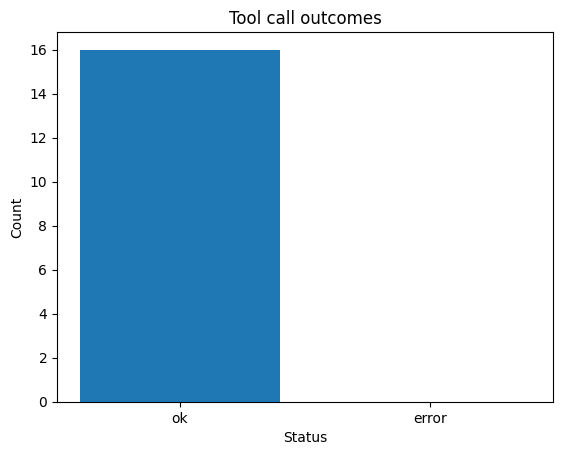

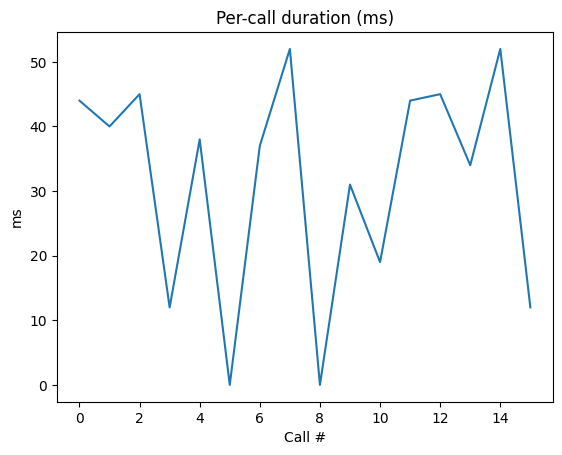

In [10]:
import matplotlib.pyplot as plt
ok=sum(1 for r in REG.audit if r["result"]["status"]=="ok")
err=sum(1 for r in REG.audit if r["result"]["status"]!="ok")
plt.figure(); plt.bar(["ok","error"],[ok,err]); plt.title("Tool call outcomes"); plt.xlabel("Status"); plt.ylabel("Count"); plt.show()

dur=[row["result"].get("duration_ms",0) for row in REG.audit]
if dur:
    plt.figure(); plt.plot(dur); plt.title("Per-call duration (ms)"); plt.xlabel("Call #"); plt.ylabel("ms"); plt.show()
else:
    print("No calls recorded.")